Chào thầy và các bạn hôm nay nhóm chúng mình sẽ nói về thuật toán K-nearest neighbors và áp dụng thuật toán vào bài toán cụ thể

- Thuật toán K-nearest neighbors (KNN) là thuật toán thuộc nhóm supervised-learning . Khi training thuật toán không học một điều gì ở dữ liệu hết . Mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới
- Thuật toán KNN có thể áp dụng vào cả hai loại của bài toán supervised-learning là classifition và regression

Để triển khai thuật toán có 3 bước đơn giản như sau:

- Tính khoảng cách (Euclidean,mathattan,minkowski)
- Nhận hàng xóm gần nhất
- Đưa ra dự đoán

# Bài toán cụ thể :
Dự đoán và phân loại khách hàng ngưng giao dịch

![Image of Yaktocat](https://www.tellius.com/wp-content/uploads/2018/06/Churn.png)

1. Giới thiệu
    - Xác định và hình dung những yếu tố bài góp phần vào việc ngưng giao dịch khách hàng
    - Xây dựng mô hình dự đoán
        - Phân loại xem liệu khách hàng có bỏ cuộc hay không bỏ cuộc
        - Dựa trên hiệu suất và đánh giá mô hình

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [28]:
data = pd.read_csv('Churn_Modelling.csv')

In [29]:
data.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [30]:
data.shape

(10000, 14)

Dữ liệu có 10000 dòng và 14 cột . Bây giờ sẽ kiểm tra từng đặc trưng và các thành phân trong đặc trưng

In [31]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Đọc dữ liệu ra ta thấy dữ liệu được lấy tại 1 thời điểm nào đó . Có những khách hàng đã ngưng giao dịch nhưng vẫn còn số dư trong tài khoản . Điều này có nghĩa là họ đã tạm ngưng vào 1 giao dịch nào đó chứ không phải ngưng giao dịch hẳn luôn

# Phân tích dữ liệu

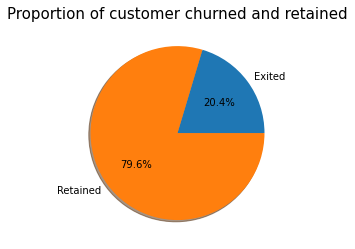

In [32]:
labels = 'Exited','Retained'
sizes = [data.Exited[data['Exited']==1].count(),data.Exited[data['Exited']==0].count()]
plt.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',shadow=True)
plt.title("Proportion of customer churned and retained", size = 15)
plt.show()

Ta thấy thì có tầm 20.4% khách hàng ngưng giao dịch và 79.6% khách hàng vẫn tiếp tục giao dịch . Trong tập dữ liệu này thì tỉ lệ ngưng giao dịch và còn giao dịch nó không đồng đều

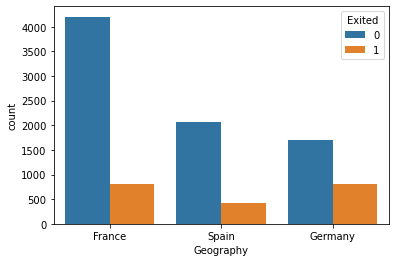

In [33]:
sns.countplot(x='Geography',hue='Exited',data = data)

Phần lớn đa số khách hàng là người pháp và tỉ lệ ngưng giao dịch ở đây nó tỉ lệnh nghịch với geography

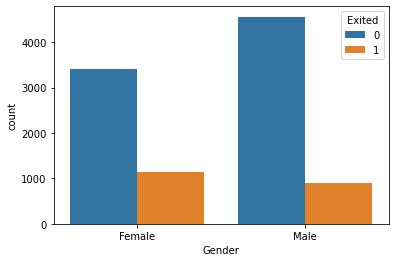

In [34]:
sns.countplot(x='Gender',hue='Exited',data=data)

Đa số khách hàng là nam nhưng tỉ lệ ngưng giao dịch cao lại là nữ

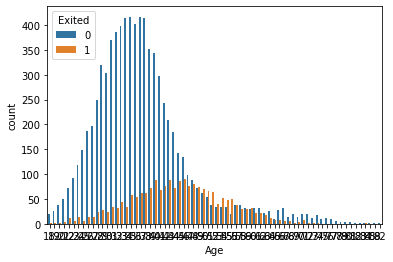

In [35]:
sns.countplot(x='Age',hue='Exited',data=data)

Độ tuổi trung bình ở đây là từ 25-45 tuổi 

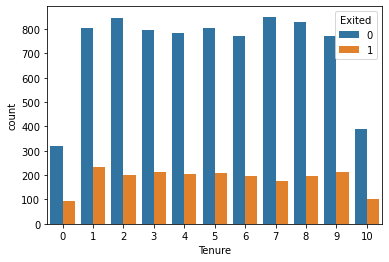

In [36]:
sns.countplot(x='Tenure',hue='Exited',data=data)

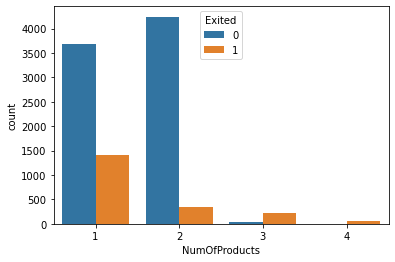

In [37]:
sns.countplot(x='NumOfProducts',hue='Exited',data=data)

Số chương trình tham gia giao dịch càng ít thì tỉ lệ ngưng giao dịch càng cao

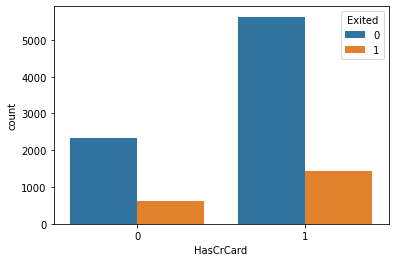

In [38]:
sns.countplot(x="HasCrCard",hue='Exited',data=data)

Điều thú vị là phần lớn khách hàng đã bỏ tiền là những người có thẻ tín dụng.  Cho rằng phần lớn khách hàng có thẻ tín dụng có thể chứng minh điều này chỉ là một sự trùng hợp.

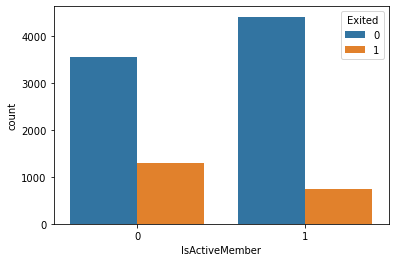

In [39]:
sns.countplot(x='IsActiveMember',hue='Exited',data=data)

Không có gì đáng ngạc nhiên khi các thành viên không hoạt động có một sự xáo trộn lớn hơn.  Đáng lo ngại là tỷ lệ khách hàng không hoạt động nói chung là khá cao, cho thấy ngân hàng có thể cần một chương trình thực hiện để chuyển nhóm này thành khách hàng tích cực vì điều này chắc chắn sẽ có tác động tích cực đến việc bỏ vốn của khách hàng.

# Tiền xử lý dữ liệu

Mã hoá số : ta gán mỗi giá trị của đăng trưng dạng nhóm thành một số bất kỳ và khác nhau từng đôi một

In [40]:
gender_col = {'Female':0,'Male':1}
data['Gender'] = data['Gender'].map(gender_col)

In [41]:
geo_col = {'France':0,'Germany':1,'Spain':2}
data['Geography'] = data['Geography'].map(geo_col)

Drop nhưng cột nào ko ảnh hưởng tới đầu ra và muốn dữ liệu liên tục để tính khoảng cách

In [42]:
data = data.drop(['RowNumber','CustomerId','Surname'],1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1


In [43]:
data.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.746300,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Chuẩn hoá dữ liệu

In [44]:
def xuly(data):
    for i in range(data.shape[1]):
        data.iloc[:,i] = data.iloc[:,i]/np.abs(max(data.iloc[:,i]))
    return data

In [45]:
data = xuly(data)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.728235,0.0,0.0,0.456522,0.2,0.000000,0.25,1.0,1.0,0.506763,1.0
1,0.715294,1.0,0.0,0.445652,0.1,0.334031,0.25,0.0,1.0,0.562734,0.0
2,0.590588,0.0,0.0,0.456522,0.8,0.636357,0.75,1.0,0.0,0.569679,1.0
3,0.822353,0.0,0.0,0.423913,0.1,0.000000,0.50,0.0,0.0,0.469151,0.0
4,1.000000,1.0,0.0,0.467391,0.2,0.500246,0.25,1.0,1.0,0.395435,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.907059,0.0,1.0,0.423913,0.5,0.000000,0.50,1.0,0.0,0.481371,0.0
9996,0.607059,0.0,1.0,0.380435,1.0,0.228657,0.25,1.0,1.0,0.508518,0.0
9997,0.834118,0.0,0.0,0.391304,0.7,0.000000,0.25,0.0,1.0,0.210436,1.0
9998,0.908235,0.5,1.0,0.456522,0.3,0.299226,0.50,1.0,0.0,0.464460,1.0


In [46]:
n,m = data.shape
n,m

(10000, 11)

Chia dữ liệu X,Y để phục vụ cho việc tính toán

In [47]:
X = data.iloc[:,0:m].values
Y = data.iloc[:,m-1].values

Chia dữ liệu ra 2 tập : training và test theo 80% cho việc traing và 20% test

In [48]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = .2)

In [49]:
one = np.ones((x_train.shape[0],1))
x_train = np.concatenate((one,x_train),1)

Viết hàm tìm phần tử xuất hiện nhiều nhất trong list

In [50]:
def FindMostOccur(arr):
    labels = set(arr)
    ans = []
    MaxOccur = 0
    for i in labels:
        num = arr.count(i)
        if num > MaxOccur:
            MaxOccur = num
            ans = i
    return ans

- Tính khoảng cách bằng công thức euclidean , duyệt qua tất cả các thuộc tính tương ứng mỗi điểm tính tổng của hiệu bình phương mỗi thuộc tính rồi trả về căn bậc 2
- Hàm này sẽ duyệt qua tất cả các giá trị trong train, tính khoảng cách giữa điểm truyền vào với những điểm trong tập dữ liệu ban đầu
- Sau đó chúng ta sắp xếp tăng dần cho list với giá trị so sánh khoảng cách 
- Tiếp là gọi hàm FindMostOccur() để tìm các phần tử nhiều nhất và trả về các nhãn

In [51]:
def KNN(x,point,k):
    x[:,0]  = 0
    for i in range(1,x.shape[1]-1):
        x[:,0]=x[:,0]+(x[:,i]-point[i-1])**2
    x[:,0] = x[:,0]**(1/2)
    
    x = x[np.argsort(x[:,0])]
    
    listt = x[0:k,x.shape[1]-1].tolist()
    labels = FindMostOccur(listt)
    
    return labels

In [52]:
KNN(x_train,x_test[1,:],5)

0.0

Cuối cùng chúng ta sẽ duyệt qua các giá trị trong bộ giữ liệu test để kiểu tra

In [53]:
def train_test_KNN(x_train,x_test,k):
    labels = list()
    n = x_test.shape[0]
    for i in range(n):
        knn = KNN(x_train,x_test[i,:],k)
        labels.append(knn)
    return labels

# Đánh giá hiệu suất mô hình

In [56]:
def accuray(y_test,label):
    return np.mean(y_test==label)

In [57]:
k = range(1,10)
kn ={}
for i in k:
    kn[i]=(accuray(y_test,train_test_KNN(x_train,x_test,k=i)))

In [58]:
kn

{1: 0.776,
 2: 0.799,
 3: 0.796,
 4: 0.8015,
 5: 0.803,
 6: 0.803,
 7: 0.8035,
 8: 0.8025,
 9: 0.8005}

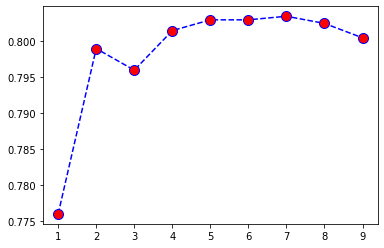

In [59]:
plt.plot(range(1,10),list(kn.values()),color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)

In [60]:
result = train_test_KNN(x_train,x_test,5)
print(f'predict labels: {result}')

predict labels: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [61]:
accuray(y_test,result)

0.803

# Hiệu suất mô hình

In [62]:
from sklearn.metrics import *

In [63]:
np.unique(y_test,return_counts=True)

(array([0., 1.]), array([1580,  420], dtype=int64))

In [64]:
confusion = confusion_matrix(y_test,result)
confusion

array([[1480,  100],
       [ 294,  126]], dtype=int64)

In [65]:
print(classification_report(y_test,result))

              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      1580
         1.0       0.56      0.30      0.39       420

    accuracy                           0.80      2000
   macro avg       0.70      0.62      0.64      2000
weighted avg       0.78      0.80      0.78      2000



In [66]:
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [67]:
print(f'dự đoán tích cực {TP/(TP+FP)}')
print(f'dự đoán tiêu cực {TN/(TN+FN)}')

dự đoán tích cực 0.5575221238938053
dự đoán tiêu cực 0.8342728297632469


- Đường cong ROC là số liệu quan trọng để trực quan hoá hiệu xuất 
- AUC chỉ ra rằng xác suất của một ví dụ tích cực được chọn ngẫu nhiên sẽ được bộ phân loại cho điểm cao hơn

In [68]:
fpr,tpr,thresholds = roc_curve(y_test,result)

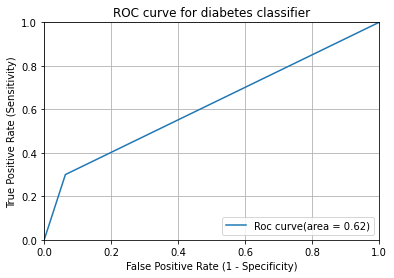

In [69]:
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='Roc curve(area = %.2f)'%roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)